# Creative Text Generation with Recurrent Neural Networks (RNNs)

In this assignment, you'll build upon your understanding of RNNs and Keras to develop a word-level text generation model.  Your goal is to train a model that learns the stylistic nuances of a chosen corpus and generates new, original text segments that echo the source material's essence.

**Datasets**

We've provided several intriguing text corpora to get you started:

*   Mark Twain
*   Charles Dickens
*   William Shakespeare

**Feel free to explore!**  If you have a particular passion for another author, genre, or a specific text, you're encouraged to use your own dataset of raw text.

In [1]:
# Check if we have a GPU available
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU available. If you're on Colab, go to Runtime > Change runtime and select a GPU hardware accelerator.")

Default GPU Device: /device:GPU:0


In [2]:
import requests
import os

def download_file(book_name):
    base_url = "https://raw.githubusercontent.com/UofT-DSI/deep_learning/refs/heads/main/02_activities/assignments/downloaded_books/"
    file_url = base_url + book_name
    local_filename = book_name

    response = requests.get(file_url)
    if response.status_code == 200:
        with open(local_filename, 'w', encoding='utf-8') as f:
            f.write(response.text)
        print(f"Downloaded {book_name} successfully!")
        return local_filename
    else:
        raise ValueError("Failed to download the file. Please check the filename and try again.")

def load_dataset(file_path, fraction=1.0):
    with open(file_path, 'r', encoding='utf-8') as f:
        raw_text = f.read()
    return raw_text[:int(fraction * len(raw_text))]

# Prompt user to select a book
title_options = {
    "1": "charles_dickens.txt",
    "2": "mark_twain.txt",
    "3": "shakespeare.txt"
}

print("Choose a book to download:")
print("1: Charles Dickens")
print("2: Mark Twain")
print("3: William Shakespeare")

choice = None
while choice not in title_options:
    choice = input("Enter the number corresponding to your choice (1, 2, or 3): ").strip()
    if choice not in title_options:
        print("Invalid choice. Please enter 1, 2, or 3.")

selected_book = title_options[choice]
file_path = download_file(selected_book)

# Load chosen dataset
fraction = 0.1  # Adjust fraction if running out of memory
text = load_dataset(file_path, fraction=fraction)

print("Dataset loaded successfully!")

Choose a book to download:
1: Charles Dickens
2: Mark Twain
3: William Shakespeare
Enter the number corresponding to your choice (1, 2, or 3): 3
Downloaded shakespeare.txt successfully!
Dataset loaded successfully!


# 1. Data Preparation (10 Marks)

Before we can begin training an RNN model, we need to prepare the dataset. This involves cleaning the text, tokenizing words, and creating sequences the model can be trained on.

## 1.1 Data Exploration (3 Marks)

Print the first 1000 characters of the dataset. Report the dataset's size and the number of unique characters it contains.

In [3]:
# Solution
print(text[:1000])
print('The dataset contains {} characters.'.format(len(text)))
unique_chars = sorted(set(text))
print('The dataset contains {} unique characters.'.format(len(unique_chars)))

The Project Gutenberg EBook of Hamlet, by William Shakespeare

This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org


Title: Hamlet

Author: William Shakespeare

Editor: Charles Kean

Release Date: January 10, 2009 [EBook #27761]

Language: English

Character set encoding: UTF-8

*** START OF THIS PROJECT GUTENBERG EBOOK HAMLET ***




Produced by David Starner, Curtis Weyant and the Online
Distributed Proofreading Team at https://www.pgdp.net









    Transcriber's Note:
    This is a heavily edited version of _Hamlet_. It was used
    for Charles Kean's 1859 stage production. Phrases printed
    in italics in the book are indicated in this electronic
    version by _ (underscore). Footnotes originally appeared
    at the bottom of each page. For this electronic version
    the footnotes 

## 1.2 Text Pre-Processing (4 Marks)

To prepare the dataset for training, we need to clean the text and create a numerical representation the model can interpret. Perform the following pre-processing steps:

*   Convert the entire text to lowercase.
*   Use the `Tokenizer` class from the `keras.preprocessing.text` module to tokenize the text. You should fit the tokenizer on the text and then convert the text to a sequence of numbers. You can use the `texts_to_sequences` method to do this.

**Note**:
* You'll need to specify an appropriate size for the vocabulary. The number of words in the list of most common words can serve as a guide - does it seem like a reasonable vocabulary size?
* Some of the words will be excluded from the vocabulary, as they don't appear often enough. It's important to provide a value for `oov_token` when creating the Tokenizer instance, so that these words can be represented as "unknown".

In [4]:
# Solution
from tensorflow.keras.preprocessing.text import Tokenizer

# Define vocabulary size and OOV token
VOCAB_SIZE = 1000  # This is a reasonable to accommodate System RAM
OOV_TOKEN = "<UNK>"  # Standard token for out-of-vocabulary words

# Convert the entire text to lowercase
text_lower = text.lower()

# Tokenize the text by splitting it into words
# We need to split the text into words first for the tokenizer
words = text_lower.split()

# Create and fit the tokenizer
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts([text_lower])  # Fit tokenizer on the lowercase text

# This will create the word-to-index mapping based on word frequency

If everything worked, the following line should show you the first 10 words in the vocabulary:

In [5]:
print(list(tokenizer.word_index.items())[:10])

[('<UNK>', 1), ('the', 2), ('and', 3), ('of', 4), ('to', 5), ('a', 6), ('in', 7), ('i', 8), ('that', 9), ('you', 10)]


## 1.3 Sequence Generation (3 Marks)

Now that the text has been tokenized, we need to create sequences the model can be trained on. There are two parts to this:

*   Use the `texts_to_sequences` method from the tokenizer to convert the text to a list of sequences of numbers.
*   Generate the training sequences. Each training sequence should contain `SEQ_LENGTH` token IDs from the text. The target token for each sequence should be the word that follows the sequence in the text.

In [6]:
# Solution
SEQ_LENGTH = 20  # Length of input sequences (words used to predict the next word)

# Convert the text to a list of sequences of numbers
# We'll use the texts_to_sequences method on our tokenized text
tokenized_text = tokenizer.texts_to_sequences([text_lower])[0]

# Generate the training sequences
X = []
y = []

# Create input sequences and their corresponding targets
for i in range(len(tokenized_text) - SEQ_LENGTH):
    # Input sequence is SEQ_LENGTH tokens
    input_sequence = tokenized_text[i:i + SEQ_LENGTH]
    # Target is the next token after the sequence
    target = tokenized_text[i + SEQ_LENGTH]

    X.append(input_sequence)
    y.append(target)

print(f"Created {len(X)} training sequences")

Created 156651 training sequences


Assuming your sequences are stored in `X` and the corresponding targets in `y`, the following line should print the first training sequence and its target:

In [7]:
print(f'Sequence: {X[0]}\nTarget: {y[0]}')
print(f'Translated back to words: {[tokenizer.index_word[i] for i in X[0]]} -> {tokenizer.index_word[y[0]]}')

Sequence: [2, 56, 54, 411, 4, 107, 28, 668, 172, 20, 411, 13, 16, 2, 176, 4, 669, 1, 33, 43]
Target: 1
Translated back to words: ['the', 'project', 'gutenberg', 'ebook', 'of', 'hamlet', 'by', 'william', 'shakespeare', 'this', 'ebook', 'is', 'for', 'the', 'use', 'of', 'anyone', '<UNK>', 'at', 'no'] -> <UNK>


And the following code will transform y into a one-hot encoded matrix, and split everything into training and validation sets:

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np

# Convert X and y to numpy arrays
X = np.array(X)
y = np.array(y)

# One last thing: let's drop any examples where the target is the OOV token - we don't want our model to predict that (boring!)
mask = y != tokenizer.word_index[OOV_TOKEN]
X = X[mask]
y = y[mask]

# One-hot encode the target token
y = to_categorical(y, num_classes=VOCAB_SIZE)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train shape: (95694, 20)
y_train shape: (95694, 1000)


# 2. Model Development (10 Marks)

With the dataset prepared, it's time to develop the RNN model. You'll need to define the architecture of the model, compile it, and prepare it for training.

## 2.1 Model Architecture (4 Marks)

Define the architecture of your RNN model. You can design it however you like, but there are a few features that it's important to include:

*   An embedding layer that learns a dense representation of the input tokens. You'll need to specify the input dimension (the size of the vocabulary) and the output dimension (the size of the dense representation). Remember, you can look at the documentation [here](https://keras.io/api/layers/core_layers/embedding/).
*   At least one recurrent layer. We have learned how to use LSTM layers in class, but you can use other types of recurrent layers if you prefer. You can find the documentation [here](https://keras.io/api/layers/recurrent_layers/lstm/).
*   A dense layer with a softmax activation function. This layer will output a probability distribution over the vocabulary, so that the model can make predictions about the next token.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Define model parameters
embedding_dim = 128  # Size of word embedding vectors
lstm_units = 256     # Number of LSTM units

model = Sequential([
    # Embedding layer: specify input_shape to build the model properly
    Embedding(input_dim=VOCAB_SIZE, output_dim=embedding_dim, input_shape=(SEQ_LENGTH,)),

    # First LSTM layer with dropout for regularization
    LSTM(lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),

    # Second LSTM layer
    LSTM(lstm_units, dropout=0.2, recurrent_dropout=0.2),

    # Dropout layer to prevent overfitting
    Dropout(0.4),

    # Output layer with softmax activation to predict next word probability
    Dense(VOCAB_SIZE, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 20, 128)             │         128,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 20, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1000)                │         257,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,304,552 (4.98 MB)

 Trainable params: 1,304,552 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

## 2.2 Model Compilation (3 Marks)

Compile the model with an appropriate loss function and optimizer. You might also want to track additional metrics, such as accuracy.

Give a short explanation of your choice of loss function and optimizer:

_your explanation here_

In [10]:
# Solution
# Compile the model
model.compile(
    loss='categorical_crossentropy',  # Standard loss for multi-class classification
    optimizer='adam',                 # Adam optimizer works well for most text tasks
    metrics=['accuracy']              # Track accuracy during training
)


## 2.3 Model Training (3 Marks)

Train the model on the training data you've prepared.

* Train your model for 5 epochs with a batch size of 128. Use the validation data for validation.
* Store the training history in a variable called `history`.

In [11]:
# Train the model
history = model.fit(
    X_train,                # Training sequences
    y_train,                # Target one-hot encoded words
    epochs=5,               # Train for 5 epochs as specified
    batch_size=128,         # Process 128 sequences per batch
    validation_data=(X_val, y_val),  # Use validation data to monitor overfitting
    verbose=1               # Show progress bar
)

Epoch 1/5
748/748 ━━━━━━━━━━━━━━━━━━━━ 119s 144ms/step - accuracy: 0.0515 - loss: 5.8357 - val_accuracy: 0.0693 - val_loss: 5.5114
Epoch 2/5
748/748 ━━━━━━━━━━━━━━━━━━━━ 135s 141ms/step - accuracy: 0.0768 - loss: 5.4578 - val_accuracy: 0.0969 - val_loss: 5.2384
Epoch 3/5
748/748 ━━━━━━━━━━━━━━━━━━━━ 143s 143ms/step - accuracy: 0.0994 - loss: 5.1914 - val_accuracy: 0.1136 - val_loss: 4.9793
Epoch 4/5
748/748 ━━━━━━━━━━━━━━━━━━━━ 105s 140ms/step - accuracy: 0.1177 - loss: 4.9433 - val_accuracy: 0.1310 - val_loss: 4.7966
Epoch 5/5
748/748 ━━━━━━━━━━━━━━━━━━━━ 107s 143ms/step - accuracy: 0.1316 - loss: 4.7618 - val_accuracy: 0.1421 - val_loss: 4.6915


Plot the training history to visualize the model's learning progress. Your plot should include the training and validation loss.

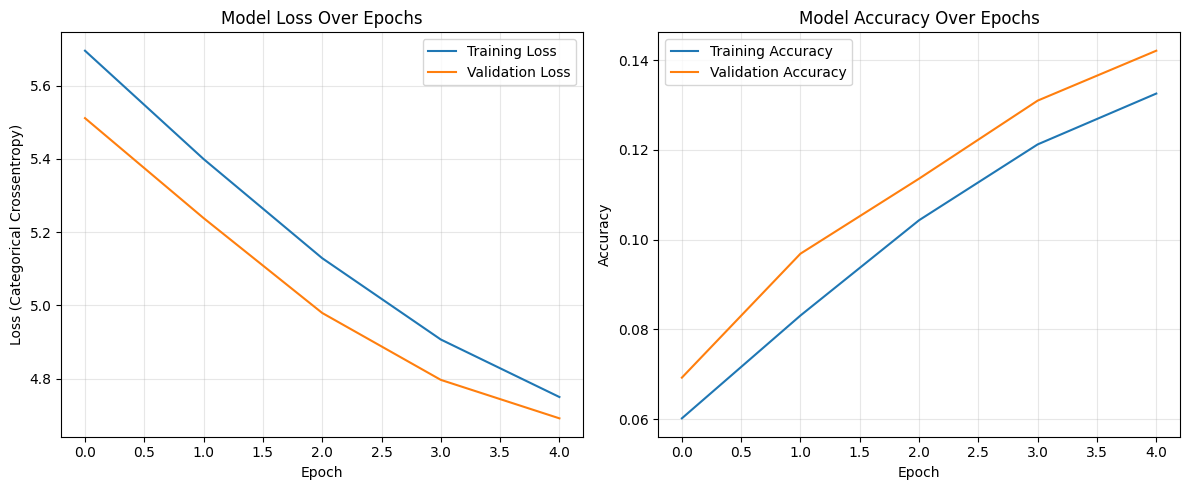

In [12]:
# Solution
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
plt.figure(figsize=(12, 5))

# Plot the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Categorical Crossentropy)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# 3. Text Generation (10 Marks)

## Task Overview

In this task, you will write a function called `generate_text` that uses a trained RNN model to generate new text based on a given seed phrase.

Your function **must** follow a structured approach to text generation, where the model predicts one word at a time, adds it to the sequence, and repeats this process until a desired length is reached.

## Function Requirements

You need to implement a function with the following signature:

```python
def generate_text(model, tokenizer, seed_text, max_sequence_len, n_words=100):
```

### **Parameters**
- `model`: The trained RNN model that will generate text.
- `tokenizer`: The tokenizer used to convert words to numerical sequences.
- `seed_text`: The initial text that will be used to start generating words.
- `max_sequence_len`: The maximum length of input sequences (same as used in training).
- `n_words` (optional, default=100): The number of words to generate.

### **Expected Output**
- A single **string** containing the generated text.

---

## **Step-by-Step Instructions**

### **1. Tokenize the seed text**
Use the tokenizer to convert `seed_text` into a sequence of numbers:

```python
encoded = tokenizer.texts_to_sequences([seed_text])[0]
```

### **2. Pad the sequence to match training input length**
Ensure that the sequence is the correct length by padding it **at the beginning**:

```python
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoded = pad_sequences([encoded], maxlen=max_sequence_len, truncating='pre')
```

### **3. Predict the next word**
Pass the padded sequence to the model to predict the next word.

- The model will output a probability distribution over the vocabulary.
- Use `np.random.choice` or `np.argmax` to select the most likely word.

```python
yhat = model.predict(encoded, verbose=0)
predicted_word_index = np.argmax(yhat)  # Select the word with the highest probability
```

### **4. Convert the predicted word index to a word**
Find the corresponding word in the tokenizer’s vocabulary:

```python
out_word = tokenizer.index_word[predicted_word_index]
```

### **5. Append the new word to the generated text**
- Add the predicted word to `seed_text`.
- Repeat the process to generate multiple words.

```python
seed_text += " " + out_word
```

### **6. Repeat Steps 3-5 until `n_words` have been generated**

- Each time, remove the oldest word from the input sequence to keep its length constant.
- Continue generating words one at a time until reaching `n_words`.

---

## **Important Notes**
- If the generated text doesn’t make much sense, don’t worry! The quality will improve as the model is trained better.
- This is a **challenging** task! If you get stuck, ask for help.
- The `generate_text` function should return the **full generated text as a single string**.

### **Example Usage**
After implementing `generate_text`, you should be able to call it like this:

```python
generated_text = generate_text(model, tokenizer, "Once upon a time", max_sequence_len=20, n_words=50)
print(generated_text)
```

This should output a string of 50 words generated by the model, starting with `"Once upon a time"`.

In [13]:
# Solution
def generate_text(model, tokenizer, seed_text, max_sequence_len, n_words=100):
    """
    Generate text using a trained RNN model.

    Parameters:
    - model: The trained RNN model
    - tokenizer: The tokenizer used during training
    - seed_text: Initial text to start generation
    - max_sequence_len: Maximum length of input sequences
    - n_words: Number of words to generate

    Returns:
    - A string containing the generated text
    """
    # Convert seed text to lowercase to match training data
    seed_text = seed_text.lower()

    # Store the original seed text to return later
    result = seed_text

    for _ in range(n_words):
        # 1. Tokenize the current text
        token_list = tokenizer.texts_to_sequences([seed_text])[0]

        # 2. Pad the sequence to match training input length
        from tensorflow.keras.preprocessing.sequence import pad_sequences
        padded_sequence = pad_sequences([token_list], maxlen=max_sequence_len,
                                       truncating='pre')

        # 3. Predict the next word
        yhat = model.predict(padded_sequence, verbose=0)

        # Option 1: Select the word with highest probability
        # predicted_word_index = np.argmax(yhat)

        # Option 2: Sample from the probability distribution for more variety
        # Convert probabilities to a proper distribution that sums to 1
        yhat = yhat[0]
        # Apply temperature to control randomness (lower = more conservative)
        temperature = 0.7
        yhat = np.log(yhat) / temperature
        exp_yhat = np.exp(yhat)
        yhat = exp_yhat / np.sum(exp_yhat)

        # Sample from the distribution
        predicted_word_index = np.random.choice(len(yhat), p=yhat)

        # 4. Convert the predicted word index to a word
        out_word = tokenizer.index_word.get(predicted_word_index, "<UNK>")

        # 5. Append the new word to the generated text
        result += " " + out_word

        # Update seed_text for next iteration by adding the new word
        # and keeping only the most recent words to maintain context
        seed_text += " " + out_word

        # If seed_text gets too long, keep only the most recent words
        seed_text_words = seed_text.split()
        if len(seed_text_words) > max_sequence_len:
            seed_text = " ".join(seed_text_words[-max_sequence_len:])

    return result


In [14]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

'hamlet they are more and dost i am it is our right home i know my lord it i with it will give him ” said her else and i have not her ” said ” said the polonius who should make the duke that his merry love and i have go to the play and then draw the sea ant s you thou and say thou more i am from you nor i would be my c my mistress if i will not like it that you are as thou morrow what are my lord ham leave me or that'

# 4. Model Refinement (5 Marks)

## **Understanding Your Model's Performance**

At this stage, you might have noticed that the text generated by your model doesn’t make much sense yet. **This is completely expected!**

There are a few reasons why:
1. **RNNs have limitations** – While they can generate sequences, they struggle with long-range dependencies in text.
2. **Character-by-character generation is outdated** – Modern models like ChatGPT don’t generate text one letter at a time. Instead, they use **tokens**, which represent larger chunks of words, making their outputs much more coherent.
3. **Training time and data size** – Our model has been trained on a relatively small dataset for a short period of time, which means it hasn’t learned enough patterns to generate meaningful text.

Even though we don’t expect ChatGPT-level performance, this exercise is about **experimentation, not perfection**. Your goal here is to try **at least one** way to refine your model and observe how it affects the output.

---

## **Refining Your Model**
There are many ways to try improving your model. Here are some ideas:

✅ **Use pre-trained embeddings**  
   Instead of learning word representations from scratch, you can use pre-trained word embeddings. This allows your model to start with a better understanding of word relationships.

✅ **Modify the model architecture**  
   - Experiment with **more layers** or different numbers of units per layer.  
   - Try adding **dropout layers** to prevent overfitting.  
   - Consider using **bidirectional RNNs**, which process text in both forward and backward directions.  

✅ **Train for longer**  
   - Try increasing the number of **epochs** (but be mindful of overfitting).  
   - Experiment with different **batch sizes** to see if they affect training stability.  

Again, **perfection is NOT the goal here** – we just want to see that you experimented with improving your model! 🚀

In [15]:
!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2025-03-10 03:36:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  4.63MB/s    in 2m 47s  

2025-03-10 03:39:18 (4.93 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [16]:
# Load the pre-trained embeddings
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [17]:
# Create an embedding matrix
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [18]:
embedding_layer = Embedding(
    VOCAB_SIZE, 100, weights=[embedding_matrix], trainable=False
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 20, 100)             │         100,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 20, 512)             │         731,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 256)                 │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1000)                │         257,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,941,384 (7.41 MB)

 Trainable params: 1,841,384 (7.02 MB)

 Non-trainable params: 100,000 (390.62 KB)

Epoch 1/10
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 301s 195ms/step - accuracy: 0.0665 - loss: 5.6800 - val_accuracy: 0.1068 - val_loss: 5.0423
Epoch 2/10
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 320s 194ms/step - accuracy: 0.1086 - loss: 4.9801 - val_accuracy: 0.1274 - val_loss: 4.7577
Epoch 3/10
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 320s 192ms/step - accuracy: 0.1281 - loss: 4.7468 - val_accuracy: 0.1394 - val_loss: 4.6531
Epoch 4/10
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 322s 192ms/step - accuracy: 0.1412 - loss: 4.5854 - val_accuracy: 0.1491 - val_loss: 4.5688
Epoch 5/10
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 313s 186ms/step - accuracy: 0.1485 - loss: 4.4790 - val_accuracy: 0.1577 - val_loss: 4.5000
Epoch 6/10
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 324s 188ms/step - accuracy: 0.1555 - loss: 4.3927 - val_accuracy: 0.1625 - val_loss: 4.4571
Epoch 7/10
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 330s 193ms/step - accuracy: 0.1629 - loss: 4.2966 - val_accuracy: 0.1656 - val_loss: 4.4245
Epoch 8/10
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 314s 188ms/step - ac

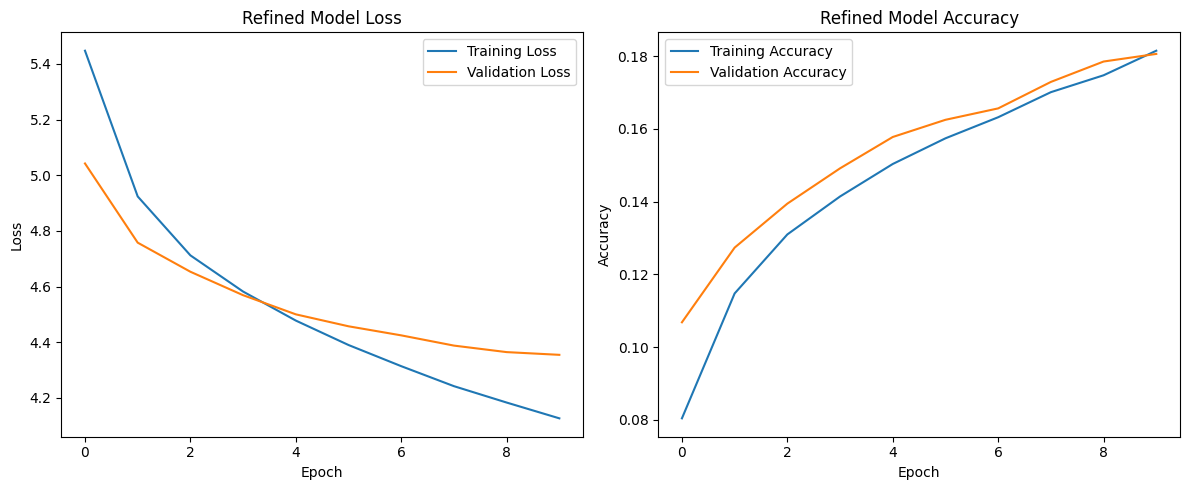

<ipython-input-13-4400214668fb>:42: RuntimeWarning: divide by zero encountered in log
  yhat = np.log(yhat) / temperature


Text generated by refined model:
hamlet of brutus the state of the first scene of the first first edition of the first line julius cæsar and cassius produced in plutarch cæsar on the original old text of the street shakespeare it is not the title is followed in the original act of the public domain the united states 1 f 9 through 1 f 3 limited right of replacement or refund 1 f 6 limited right of replacement or refund 1 f 3 limited right of replacement or refund 1 f 3 limited right of electronic work you must comply either copies of use or distributing


In [19]:
# Solution
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping  # Missing import
import matplotlib.pyplot as plt

# Create a more sophisticated model with pre-trained embeddings
refined_model = Sequential([  # Renamed to refined_model for clarity
    # Use the pre-trained GloVe embeddings with explicit input shape
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=100,  # GloVe vectors are 100-dimensional
        weights=[embedding_matrix],
        trainable=False,  # Freeze the embeddings
        input_shape=(SEQ_LENGTH,)  # Explicitly specify input shape
    ),

    # Add a bidirectional LSTM layer to capture context from both directions
    Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)),

    # Add another LSTM layer with increased capacity
    LSTM(256, dropout=0.2, recurrent_dropout=0.2),

    # Add more regularization
    Dropout(0.5),

    # Add an intermediate dense layer with ReLU activation
    Dense(256, activation='relu'),

    # Final output layer
    Dense(VOCAB_SIZE, activation='softmax')
])

# Compile with a lower learning rate for fine-tuning
refined_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# Display the model summary
refined_model.summary()

# Add early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

# Train the refined model for more epochs
refined_history = refined_model.fit(
    X_train,
    y_train,
    epochs=10,  # Increased from 5 to 10
    batch_size=64,  # Reduced from 128 to 64 for potentially better convergence
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Plot the training history
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(refined_history.history['loss'], label='Training Loss')
plt.plot(refined_history.history['val_loss'], label='Validation Loss')
plt.title('Refined Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(refined_history.history['accuracy'], label='Training Accuracy')
plt.plot(refined_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Refined Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Generate text with the refined model
refined_text = generate_text(refined_model, tokenizer, "hamlet", SEQ_LENGTH, n_words=100)
print("Text generated by refined model:")
print(refined_text)

In [21]:
# Test the text generation function
generate_text(model, tokenizer, 'hamlet', SEQ_LENGTH)

"hamlet 75 you come my c you thou as we am a island in my father before your own king she that i have in it not and to be no who is it but a devil dromio ” cried much ” said her and her thing who was to the speech prospero he had not had in her father's what he was her to be at a father had she would they be his own as his two and he was your daughter with this angelo that he said left her servant that his lord so benedick so when she"